In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from tqdm.notebook import trange

# Background

We study the vertical sinking and turbulent diffusion of particles in the water column. We make the following assumptions:
 * The time-development of the concentration is described by the advection-diffusion equation
 * The advection is due to terminal sinking velocity
 * The diffusion is due to turbulent mixing (eddy diffusivity)
 * The boundary condition at the surface is no-flux
 * The boundary condition at the sea floor is no-diffusive-flux (particles settle out if the sink to the bottom)
 * We model this with a stochastic particle model

# Theory

For a stochastic differential equation (SDE)

$$ \mathrm{d}z = a(z,t)\, \mathrm{d}t + b(z,t)\, \mathrm{d}W $$

describes how a random trajectory $z(t)$ develops in time. The link from an SDE to a concentration is that if we solve the SDE for a large ensemble of trajectories, then the distribution of trajectories can be seen as a concentration.

The Fokker-Planck equation describes time-evolution of the probability distribution, $p(z, t)$ of the trajectories described by the SDE. The Fokker-Planck equation is

$$  \frac{\partial p}{\partial t} = \frac{1}{2}\frac{\partial^2}{\partial z^2} \left( b^2 p \right) - \frac{\partial }{\partial z} (ap). $$

Conditions: $a(z,t)$ and $b(z,t)$ must be "moderately smooth functions" (Kloeden & Platen, 1992, p. 37).


The advection-diffusion equation for our case is

$$ \frac{\partial p}{\partial t} = \frac{\partial}{\partial z} \left( D \frac{\partial p}{\partial z} \right) - \frac{\partial}{\partial z} \left( v p \right), $$

where $D$ is the diffusivity, and $v$ is the terminal sinking velocity.

If we want an SDE, where the distribution of trajectories evolve according to the advection-diffusion equation, then we find (by comparing the two last equations):

\begin{align}
a(z, t) &= v + \frac{\partial D}{\partial z} \\[5pt]
b(z, t) &= \sqrt{2 K(z)}
\end{align}

# Numerical method

There are many numerical methods for SDEs, but we will mostly stick with the simplest one, the Euler-Maruyama method (Kloeden & Platen, 1992, p. 305). With this method, our discrete expression for updating particle positions is:

$$ z_{n+1} = z_n + \left( v + \left.\frac{\partial D}{\partial z}\right|_{z_n} \right) \Delta t + \sqrt{2D(z_n)} \; \Delta W_n $$

where $\Delta W_n$ are Gaussian random numbers with zero mean and variance $\sigma^2 = \Delta t$.

# Boundary conditions

For the boundary conditions, we have to split the diffusion part and the sinking part of each step.

For the surface, we enforce the no-flux boundary condition in the following way:
 * Displace particles randomly
 * Any particles that ended up above the surface are reflected to an equal distance below the surface
 * Move particles as distance $v \Delta t$ downwards
 
For the sea floor, we enforce the no-diffusive-flux boundary condition in the following way:
 * Displace particles randomly
 * Any particles that ended up below the sea floor are reflected to an equal distance above the sea floor
 * Move particles as distance $v \Delta t$ downwards
 * Any particles that ended up below the sea floor are considered settled, and removed from the simulation


See https://doi.org/10.1016/j.ocemod.2019.03.003 for additional details

# Implementation

Below follows a simple implementation of the described model.

In [37]:
def randomstep(z, K, dKdz, dt):
    dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=len(z))
    return z + dKdz(z)*dt + np.sqrt(2*K(z))*dW


def sink(z, v, dt):
    # Note: z and v are positive downwards
    return z + v*dt


def reflect(z, bottom = None):
    # Reflect from surface and optionally bottom
    # z is depth positive downwards
    # Reflect from surface
    z = np.abs(z)
    if bottom is not None:
        # Reflect from bottom
        z[ z >  bottom] =  2*bottom - z[z >  bottom]
    return z


def settle(z, bottom):
    # Keep only those particles that are above the bottom
    mask = z > bottom
    return z[~mask]


def experiment(Z0, K, dKdz, v, Zmax, Tmax, dt, Nbins=100, Nskip=10):
    # Number of timesteps
    Nt   = int(Tmax / dt) + 1
    # Arrays to store concentration profiles
    bins = np.linspace(0, Zmax, Nbins+1)
    concentrations = np.zeros(shape = (Nbins, int(Nt/Nskip)+1))
    # Copy input array to avoid overwriting
    Z = Z0.copy()
    
    #### Perform simulation ####
    for n in trange(Nt):
        # Store concentrations every Nskip steps
        if n % Nskip == 0:
            concentrations[:,int(n/Nskip)] = np.histogram(Z, bins)[0]
        # Perform random walk
        Z = randomstep(Z, K, dKdz, dt)
        # Reflect trajectories that end up outside
        Z = reflect(Z, bottom=Zmax)
        # Sinking
        Z = sink(Z, v, dt)
        # Remove particles that sunk to the bottom
        Z = settle(Z, Zmax)
    return concentrations, bins

In [51]:
#### Parameters ####
Np    = 100000     # Number of particles
Tmax  = 12 * 3600.0 # Integration time
dt    = 30         # Timestep
Nskip = 10         # Store every Nskip steps
Zmax  = 20         # Max depth
v     = 6e-4       # Sinking (or rising) speed
Nbins = 100        # Concentration bins

#### Variable diffusivity profile ####
K0 = 2e-4
K1 = 2e-3
alpha  = 0.5
K    = lambda z: K0 + z*K1*np.exp(-alpha*z)
dKdz = lambda z: K1*np.exp(-alpha*z) - alpha*z*K1*np.exp(-alpha*z)

#### Initial Gaussian distribution ####
Z0 = np.random.normal(loc=7, scale=2, size=Np)
Z0 = reflect(Z0, bottom=Zmax) # Make sure no particles are initially outside

#### Run simulation ####
C, bins = experiment(Z0, K, dKdz, v, Zmax, Tmax, dt, Nbins=Nbins, Nskip=Nskip)

Text(0, 0.5, 'Remaning fraction')

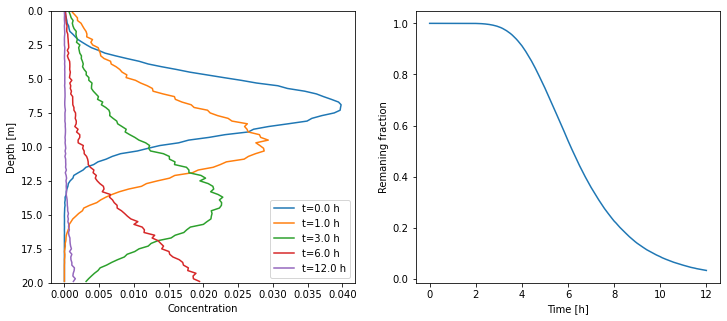

In [52]:
#### Plot results ####

# Coordinates for plotting
dz = bins[1] - bins[0]
zc = bins[:-1] + dz/2
t  = np.linspace(0, Tmax, C.shape[1])

fig, ax = plt.subplots(ncols=2, figsize=(12,5))

# Plotting concentrations
for i in [0, 12, 36, 72, 144]:
    ax[0].plot(C[:,i]/Np, zc, label=f't={i*dt*Nskip/3600} h')
    ax[0].set_ylim(Zmax, 0)

ax[0].legend()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Concentration')

# Plotting remaining fraction
ax[1].plot(t/3600, np.sum(C, axis=0)/Np)
ax[1].set_xlabel('Time [h]')
ax[1].set_ylabel('Remaning fraction')
